## 03 Изследване на статисически зависимости
### Съдържание
1. Използвани библиотеки
2. Подготовка за моделиране
3. Корелационен анализ
4. Регресионен анализ

#### 1. Използвани библиотеки
Изпозват се библиотеките pandas, numpy, matplotlib, seaborn и statsmodels.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#### 2. Подготовка за моделиране
Файла се прочита

In [2]:
data = pd.read_excel(r'/home/nitro5/Desktop/data/GIS/2nd_semestur/cartography/data_final.xlsx')

Преглед на имената на колонките.

In [3]:
data.columns

Index(['№', 'Дървесен вид', 'Вид на документа', 'Номер на документа', 'Дата',
       'ДВ', 'Населено място', 'Община', 'Област', 'РИОСВ', 'Възраст в години',
       'Височина', 'Обиколка', 'Диаметър', 'Особености', 'Година',
       'Име на населеното място', 'Тип на населеното място',
       'Географска ширина', 'Географска дължина', 'Дубликати', 'Номер'],
      dtype='object')

Ще се използват 4те числени колонки за търсене на зависимостти между стойностите.

In [10]:
data[['Височина', 'Обиколка', 'Диаметър', 'Възраст в години']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2105 entries, 0 to 2104
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Височина          2026 non-null   object 
 1   Обиколка          1932 non-null   float64
 2   Диаметър          221 non-null    float64
 3   Възраст в години  1805 non-null   float64
dtypes: float64(3), object(1)
memory usage: 65.9+ KB


Всички колонки се конвъртират във float64 за да могат да се извършват числови операции с тях.

In [11]:
data['Височина'] = pd.to_numeric(data['Височина'], errors='coerce') # Convert to numeric
data['Височина'] = data['Височина'].astype('float64')

Прави се селекция само за тях numeric_data.

In [21]:
numeric_data = data[['Височина', 'Обиколка', 'Диаметър', 'Възраст в години']]

#### 3. Корелационен анализ
От тези колонки с изчислява корелационната матраца.

In [22]:
correlation_matrix = numeric_data.corr()

На нейна база се прави топлинна карта. По диагонала са корелациите със себе си или 1. Останалите редове и колонки са между другите. Всички стойностти имат положителна корелацая. Корелационните коефициент на Пирсъм използван тук е от -1 до 1. Има особено силна корелация между Обиколка и Диаметър. Това наляга на мисълта за мултиколиенарност.

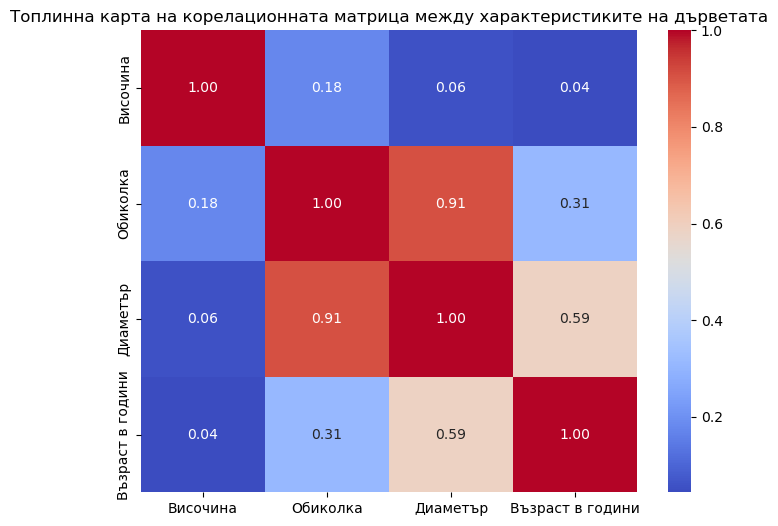

In [46]:
# Създаване на heatmap с помощта на seaborn
plt.figure(figsize=(8, 6))  # Задаване на размер на графиката (по желание)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f") #cmap="viridis" или "plasma"
plt.title("Tоплинна карта на корелационната матрица между характеристиките на дърветата")
plt.show()

За да правим калулации трябва да махнем редовете с празни стойности.

In [24]:
numeric_data.dropna(inplace=True)

/tmp/ipykernel_305160/3274882922.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_data.dropna(inplace=True)


Създаваме нова работна таблица за изчисляване на Variance Inflation Factors (VIF).

In [25]:
vif_data = pd.DataFrame()
vif_data["Variable"] = numeric_data.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_data.values, i) for i in range(numeric_data.shape[1])]

Създваме графика на стойностите и това потвърждава наличието на високи стойности между Диаметър и Обиколка. Поради тази причина ще премахнем колонката Диаметър от анализа от тук нататък.

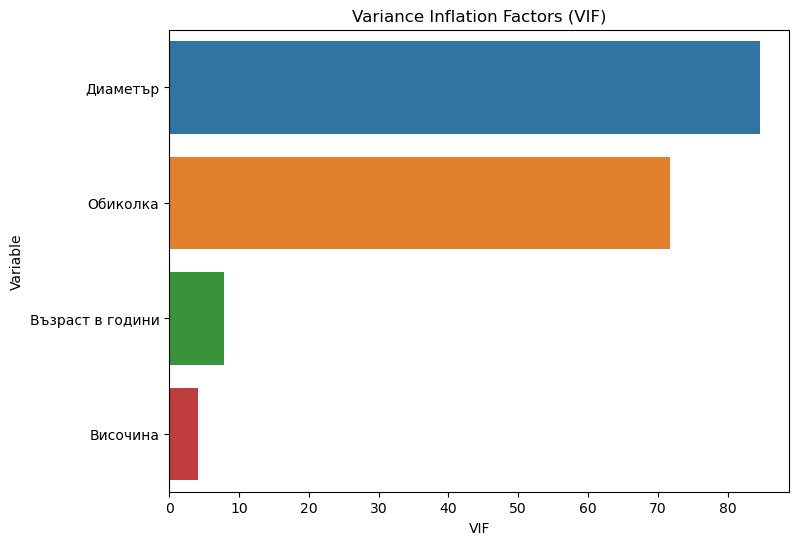

In [27]:
plt.figure(figsize=(8, 6))
sns.barplot(x="VIF", y="Variable", data=vif_data.sort_values(by="VIF", ascending=False))
plt.title("Variance Inflation Factors (VIF)")
plt.show()

Работим вече само с 3 колонки, новата работна таблица е numeric_data_selected.

In [40]:
numeric_data_selected = data[['Височина', 'Обиколка', 'Възраст в години']]
numeric_data_selected.dropna(inplace=True)

/tmp/ipykernel_305160/1477267723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_data_selected.dropna(inplace=True)


Имаме 1645 реда и 3 колонки.

In [41]:
numeric_data_selected.shape

(1645, 3)

#### 4. Регресионен анализ
За зависима променлива у избираме Височината, докато другите 2 колонки за независими.

In [42]:
y = numeric_data_selected['Височина']
X = numeric_data_selected[['Обиколка', 'Възраст в години']]

Пускаме проста регресия OLS (ordinary least squares). Тук трябва да се валидират всички допускания за този тип регресия, най-вече линейни зависимости.
Резултатите са отдолу. Имаме висок R-squared от 0,802 или с тези 2 променливи обясняваме 80% от височината на дърветата, другото се дължи на допълнителни фактори невключени от анализа и случайности. Според P>|t| двата коефициента са статистически значими, впредвид, че е по-малко от 0,05.

In [43]:
#X = sm.add_constant(X)

# Create and fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

# Print the model summary
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:               Височина   R-squared (uncentered):                   0.802
Model:                            OLS   Adj. R-squared (uncentered):              0.802
Method:                 Least Squares   F-statistic:                              3336.
Date:                Sat, 15 Feb 2025   Prob (F-statistic):                        0.00
Time:                        23:08:59   Log-Likelihood:                         -5946.0
No. Observations:                1645   AIC:                                  1.190e+04
Df Residuals:                    1643   BIC:                                  1.191e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------